In [2]:
#!pip install matplotlib --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
#!pip install torch --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#!pip install graphviz --quiet

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [5]:
def f(x):
    return 3*x**2 - 4*x +5

In [6]:
f(3.0)

20.0

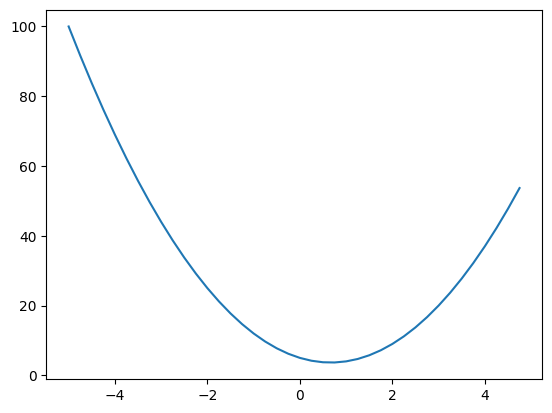

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [8]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [9]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

print(d)

4.0


In [10]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h

d2 = a*b + c

slope = (d2 - d1)/h

print("D1", d1)
print("D2", d2)
print("Slope", slope)

D1 4.0
D2 3.999699999999999
Slope -3.000000000010772


In [47]:
#value object

class Value:

    def __init__(self, data, _children=(), _op='', label=''): # _children to know cihildrens of a Value obj and _op to know which operation was applied to _children
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) #If other is not an object of value, wrap it in Value
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0  * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) #If other is not an object of value, wrap it in Value
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): #Swaps self and other values in case unable to calculate
        return self*other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x)) 
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label='e'   # Internally: (a.__mul__(b))
d = e + c; d.label='d'  # Internally: (e.__add__(c))

f = Value(-2.0, label='f')

L = d * f; L.label= 'L'
L

Value(data=-8.0)

In [29]:
a = Value(2.0)
2*a

Value(data=4.0)

In [30]:
# Set the path manually in the script
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin"

In [31]:
# Graph visualisation of network

from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #If this value is result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

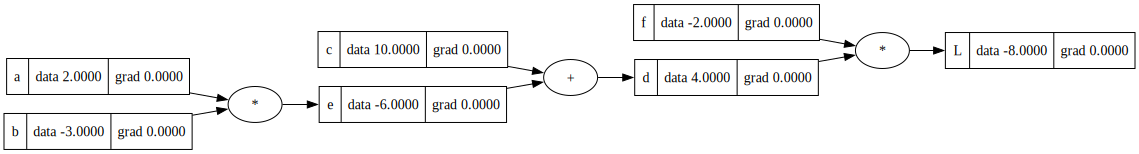

In [32]:
draw_dot(L)

In [33]:
#Calculated and updated gradients manually

d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [34]:
#Forward pass example

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [35]:
def lol():

    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'   
    d = e + c; d.label='d'  
    f = Value(-2.0, label='f')
    L = d * f; L.label= 'L'
    L1 = L.data # Used L.data instead of L to get -8.0 directly & not Value(data=-8.0)

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'   
    d = e + c; d.label='d'  
    f = Value(-2.0, label='f')
    L = d * f; L.label= 'L'
    L2 = L.data + h

    print((L2 - L1)/h)

In [36]:
lol()

1.000000000000334


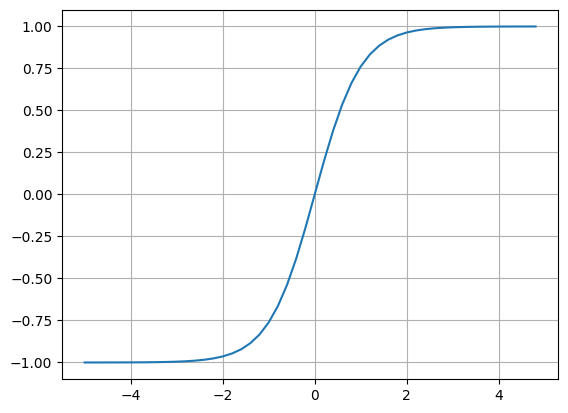

In [37]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

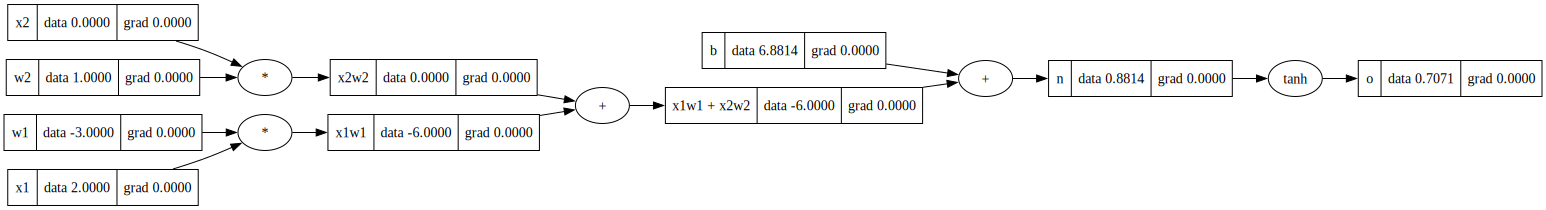

In [38]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b (input * weight + bias)
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

draw_dot(o)

In [39]:
# o = tanh(n)
# do/dn = 1 - o**2
1 - o.data ** 2

0.4999999999999998

In [40]:
"""
Manual backprop

n.grad = 0.5

x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

"""

'\nManual backprop\n\nn.grad = 0.5\n\nx1w1x2w2.grad = 0.5\nb.grad = 0.5\n\nx1w1.grad = 0.5\nx2w2.grad = 0.5\n\nx2.grad = w2.data * x2w2.grad\nw2.grad = x2.data * x2w2.grad\n\nx1.grad = w1.data * x1w1.grad\nw1.grad = x1.data * x1w1.grad\n\n'

In [41]:
"""
Using our new _backward() to backprop, but still not fully automated

#First set o to 1 to start using _backward()
o.grad = 1.0

o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

"""

'\nUsing our new _backward() to backprop, but still not fully automated\n\n#First set o to 1 to start using _backward()\no.grad = 1.0\n\no._backward()\nn._backward()\nb._backward()\nx1w1x2w2._backward()\nx1w1._backward()\nx2w2._backward()\n\n'

# **Topological Sorting in Backpropagation**
## **Need to Ensure All Dependencies Are Calculated When Backpropagating**

In computational graphs (such as those used in automatic differentiation), **topological sorting** ensures that gradients are propagated in the correct order during **backpropagation**.

A **topological sort** orders nodes in a **directed acyclic graph (DAG)** such that **each node appears before the nodes that depend on it**.

---

## **Why Do We Need Topological Sorting?**
**Backpropagation follows the chain rule**: We must compute gradients **from the final output back to the inputs**.

**Some operations depend on others**: The gradient of a parent node should only be computed **after all its children (dependencies) have been processed**.

**Ensures correct gradient accumulation**: If an intermediate node is used multiple times, its gradient must accumulate **before propagating to its parents**.

---

# **Implemented inside Value class**

In [42]:
o.backward()

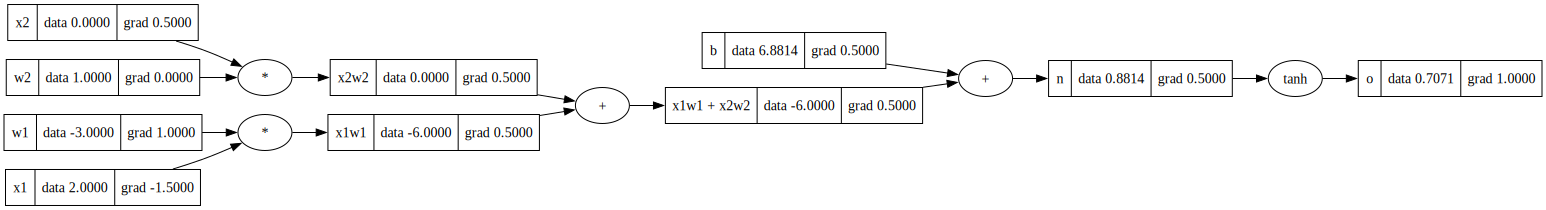

In [43]:
draw_dot(o)

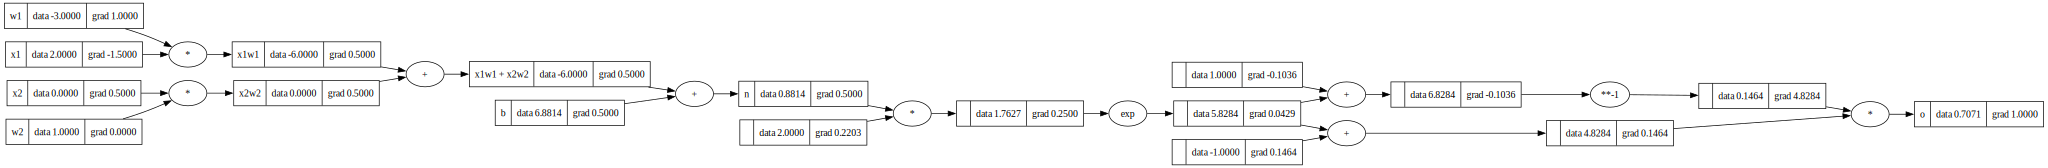

In [48]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b (input * weight + bias)
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'

#--------------------------- tanh
e = (2*n).exp()
o = (e-1) / (e+1)
#---------------------------
o.label = 'o'
o.backward()
draw_dot(o)

In [51]:
import torch

In [58]:
x1 = torch.Tensor([2.0]).double()                        ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                        ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()                       ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                        ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()          ; b.requires_grad = True

n = x1*w1 + x2*w2 + b 

o = torch.tanh(n)
print(o.data.item())

o.backward()

print('-----------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-----------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [59]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [86]:
import random
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        """
        explanation:
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps) #put on top
        return params 
        """

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [130]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9180822205667084)

In [131]:
len(n.parameters())

41

In [132]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [133]:
for k in range(20):
    #Forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)), start=Value(0)) # MSE loss

    #Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #Update (gradient descent)
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
    

0 7.4800397710282285
1 7.264530064967385
2 6.831507978163497
3 5.821478179443678
4 4.017200656900851
5 3.1176612188700847
6 2.4809287491918868
7 1.903271244813021
8 1.3716927547099687
9 0.9315449257025217
10 0.6187468663116116
11 0.4218786411225093
12 0.3022576906400588
13 0.2275881223987034
14 0.17869387610167203
15 0.1450990870991703
16 0.12101009955157212
17 0.1031009940920438
18 0.0893769416152421
19 0.07858957962349654


In [134]:
ypred

[Value(data=0.9133918807058075),
 Value(data=-0.938862335944005),
 Value(data=-0.8045677205582096),
 Value(data=0.8292457219224605)]